- This notebook is to get latent space of VICGAE
- Performance of these latent space will perfromed in another notebooks

In [1]:
from astrochem_embedding import VICGAE
import torch

In [3]:
model = VICGAE.from_pretrained()
test = model.embed_smiles("c1ccccc1")
test.shape

torch.Size([1, 32])

In [4]:
smiles = ["c1ccccc1", "[C]#N", "[13c]1ccccc1"]
embeddings = torch.stack([model.embed_smiles(s) for s in smiles])
numpy_embeddings = embeddings.numpy()

In [5]:
numpy_embeddings.shape

(3, 1, 32)

In [6]:
# Testing completed!

### Surfactants case

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

In [10]:
file_path = '/Users/haoliu/Documents/GitHub/FoundationModel_on_Liposome/data/SurfPro_v1/data/surfpro_literature.csv'
df_data = pd.read_csv(file_path)

df_ = df_data.iloc[:, [0, 1, 3]]
df_cleaned = df_.dropna()
df_data_clean = df_cleaned.reset_index(drop=True)
df_data_clean

,SMILES,Surfactant_Type,pCMC
0,C=CC(=O)OC(C[N+](C)(C)CCCCCCCCCCCC)C[N+](C)(C)...,gemini cationic,3.102373
1,C=CC(=O)OC(C[N+](C)(C)CCCCCCCCCCCCCC)C[N+](C)(...,gemini cationic,3.619789
2,C=CC(=O)OC(C[N+](C)(C)CCCCCCCCCCCCCCCC)C[N+](C...,gemini cationic,4.508638
3,C=CC(=O)OCC[N+](C)(C)CCCCCCCCCCCC.[Br-],cationic,2.384050
4,C=CC(=O)OCC[N+](C)(C)CCCCCCCCCCCCCC.[Br-],cationic,2.899629
...,...,...,...
1390,OCCOCCOCCOCCOCCOCCSCCC(F)(F)C(F)(F)C(F)(F)C(F)...,non-ionic,4.432033
1391,OCCOCCOCCOCCSCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F...,non-ionic,4.552997
1392,OCCOCCOCCSCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F...,non-ionic,4.602060
1393,OCCOCCSCCOCCSCCOCCSCCC(F)(F)C(F)(F)C(F)(F)C(F)...,non-ionic,4.585027


In [12]:
smis = df_data_clean['SMILES']
smis_list = smis.tolist()
len(smis_list)

1395

In [14]:
type(smis_list)

list

In [15]:
# Transform it to selfies list
import selfies as sf

selfies_list = [sf.encoder(smi) for smi in smis_list]


In [17]:
len(selfies_list)

1395

In [20]:
def keep_largest_fragment(smi):
    return max(smi.split('.'), key=len)

smis_list_clean = [keep_largest_fragment(s) for s in smis_list]

In [ ]:
# So here is the limitation of the package, it don't support the smiles with a '.' in it

In [21]:
embeddings = torch.stack([model.embed_smiles(s) for s in smis_list_clean])
surfactant_emb = embeddings.numpy()

In [22]:
surfactant_emb.shape

(1395, 1, 32)

In [23]:
type(surfactant_emb)

numpy.ndarray

In [25]:
surfactant_emb_2d = surfactant_emb.squeeze(1)
surfactant_emb_2d.shape

(1395, 32)

In [32]:
np.save("surfactant_emb_2d_VICGAE.npy", surfactant_emb_2d)

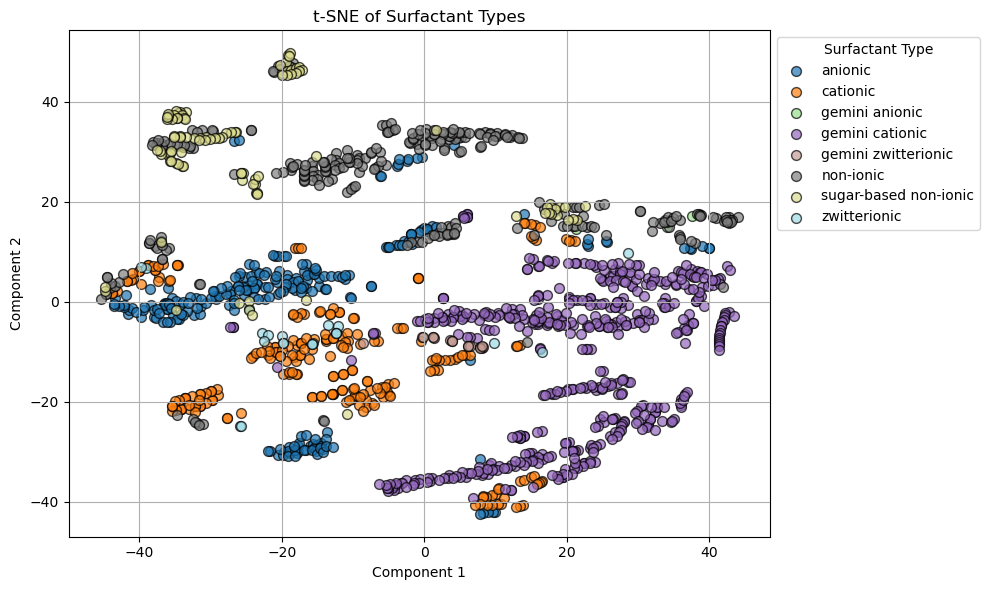

In [28]:
%matplotlib inline
# 1. Prepare input and labels
X = surfactant_emb_2d
y = df_data_clean['Surfactant_Type']

# 2. Create color dictionary
surfactant_types = np.unique(y)
colors = plt.cm.tab20(np.linspace(0, 1, len(surfactant_types)))
color_dict = dict(zip(surfactant_types, colors))

# 3. Choose dimension reduction method
reducer = TSNE(n_components=2, random_state=42)  # or PCA(n_components=2)
X_reduced = reducer.fit_transform(X)

# 4. Plot
plt.figure(figsize=(10,6))
for surfactant in surfactant_types:
    idx = (y == surfactant)
    plt.scatter(X_reduced[idx, 0], X_reduced[idx, 1], 
                color=color_dict[surfactant], 
                label=surfactant, 
                alpha=0.7, edgecolor='k', s=50)

plt.legend(title='Surfactant Type', loc='best', frameon=True, bbox_to_anchor=(1, 1))
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('t-SNE of Surfactant Types')
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:
import plotly.graph_objs as go
import plotly.io as pio

# 1. Prepare input and labels (already done)
# X = df_total.iloc[:, :768].values
# y = df_total['Surfactant_Type'].values

# 2. Choose 3D dimension reduction
reducer = TSNE(n_components=3, random_state=42)  # or PCA(n_components=3)
X_reduced = reducer.fit_transform(X)

# 3. Create Plotly traces
traces = []
for surfactant in surfactant_types:
    idx = (y == surfactant)
    trace = go.Scatter3d(
        x=X_reduced[idx, 0],
        y=X_reduced[idx, 1],
        z=X_reduced[idx, 2],
        mode='markers',
        marker=dict(
            size=5,
            color=f'rgb({color_dict[surfactant][0]*255},{color_dict[surfactant][1]*255},{color_dict[surfactant][2]*255})',
            line=dict(width=0.5, color='DarkSlateGrey')
        ),
        name=surfactant
    )
    traces.append(trace)

# 4. Layout
layout = go.Layout(
    title='t-SNE of Surfactant Types (3D)',
    scene=dict(
        xaxis_title='Component 1',
        yaxis_title='Component 2',
        zaxis_title='Component 3'
    ),
    legend=dict(title='Surfactant Type'),
    margin=dict(l=0, r=0, b=0, t=50)
)

fig = go.Figure(data=traces, layout=layout)
pio.show(fig)


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [33]:
# This environment is old, let's only get the input data here

### Binary system

In [3]:
def normalize_concentrations(df, conc_cols):
    conc_sum = df[conc_cols].sum(axis=1)
    for conc in conc_cols:
        df[conc] = df[conc] / conc_sum
    return df

In [4]:
df_mixture = pd.read_csv('df_mixture_20250502.csv')
# Normalize concentrations
conc_cols = [f'conc{i}' for i in range(1, 3)]
df_mixture_norm = normalize_concentrations(df_mixture, conc_cols)
df_mixture_norm.head()

,smi1,conc1,smi2,conc2,miscibility
0,C[C@H](CCC(=O)NCCC[N+](C)(C)CCCS(=O)(=O)[O-])[...,0.407074,CC(C)(C)CC(C)(C)C1=CC=C(C=C1)OCCO,0.592926,1
1,C[C@H](CCC(=O)NCCC[N+](C)(C)CCCS(=O)(=O)[O-])[...,0.784804,[C@H]1([C@@H]([C@@H](OC([C@H]1O)C(=O)O)O[C@H]2...,0.215196,1
2,C[C@H](CCC(=O)NCCC[N+](C)(C)CCCS(=O)(=O)[O-])[...,0.729393,C([C@@H]1[C@H]([C@@H]([C@H]([C@H](O1)O[C@@H]2[...,0.270607,1
3,C[C@H](CCC(=O)NCCC[N+](C)(C)CCCS(=O)(=O)[O-])[...,0.953164,C1[C@@H]2[C@@H]([C@H](O1)[C@H]([C@H](O2)O)OS(=...,0.046836,1
4,C[C@H](CCC(=O)NCCC[N+](C)(C)CCCS(=O)(=O)[O-])[...,0.962481,C1[C@@H]2[C@@H]([C@H](O1)[C@H]([C@H](O2)O)O)O[...,0.037519,1


In [5]:
df_mixture_norm.shape

(1378, 5)

In [6]:
import sys
sys.path.append("../src")
sys.path.append("../")

In [7]:
from VICGAE_latent import *

In [8]:
model = VICGAE.from_pretrained()


/Users/haoliu/anaconda3/envs/VICGAE/lib/python3.8/pickle.py:1579: DeprecationWarning: `torch.distributed._sharded_tensor` will be deprecated, use `torch.distributed._shard.sharded_tensor` instead
  __import__(module, level=0)


In [9]:
x_latent, y = build_mixture_latent_features_VICGAE(
    df=df_mixture_norm,
    smi_cols=['smi1', 'smi2'],
    conc_cols=['conc1', 'conc2'],
    target_col='miscibility',
    latent_fn=latent_fn_VICGAE,
    latent_fn_args={"model": model}
)

# There 52 this line are not able to process


Skipped 1 SMILES due to errors:
  - [3H]C(CC[C@@H](C(=O)NCC(=O)N[C@@H](CC1C=NC=N1)C(=O)N[C@@H](CCCN=C(N)N)C(=O)NCC(=O)N[C@@H](CC2=CC=CC=C2)C(=O)N[C@@H](CO)C(=O)NCC(=O)OC(=O)[C@H](CC(C)C)NC(=O)CN)NC(=O)[C@H](CCCC)NC(=O)CNC(=O)[C@@H]3C[C@H](CN3)O)C([3H])N: '[3H]'


In [ ]:
# smi_cols=['smi1', 'smi2']
# latent_fn_args={"model": model}
# all_smis = pd.unique(df_mixture_norm[smi_cols].values.ravel()).tolist()
# latent_vectors, skipped = latent_fn_VICGAE(all_smis, **(latent_fn_args or {}))


⚠️ Skipped 1 SMILES due to errors:
  - [3H]C(CC[C@@H](C(=O)NCC(=O)N[C@@H](CC1C=NC=N1)C(=O)N[C@@H](CCCN=C(N)N)C(=O)NCC(=O)N[C@@H](CC2=CC=CC=C2)C(=O)N[C@@H](CO)C(=O)NCC(=O)OC(=O)[C@H](CC(C)C)NC(=O)CN)NC(=O)[C@H](CCCC)NC(=O)CNC(=O)[C@@H]3C[C@H](CN3)O)C([3H])N: '[3H]'


In [11]:
print(x_latent.shape)
print(y.shape)

(1326, 32)
(1326,)


In [13]:
import joblib

In [ ]:
joblib.dump((x_latent, y), "binary_mixture_latent_VICGAE.joblib")
# x_latent, y = joblib.load("mixture_latent_data.joblib")

['binary_mixture_latent_VICGAE.joblib']

### Amphiphiles case

In [16]:
df_structured = pd.read_csv('df_structured_20250702.csv')
# Rename columns to the desired format
new_column_names = [
    'smi1', 'conc1',
    'smi2', 'conc2',
    'smi3', 'conc3',
    'smi4', 'conc4',
    'smi5', 'conc5',
    'smi6', 'conc6',
    'smi7', 'conc7',
    'vesicles_formation'
]

# Apply the new column names
df_structured.columns = new_column_names
print(df_structured.shape)
df_structured.head()

(336, 15)


,smi1,conc1,smi2,conc2,smi3,conc3,smi4,conc4,smi5,conc5,smi6,conc6,smi7,conc7,vesicles_formation
0,CCCCCCCCCC(=O)O,0.615186,CCCCCCCCCC(=O)[O-],0.955511,CCCCCCCCCCN,1.231101,CCCCCCCCCC[N+](C)(C)C.[Br-],1.552868,CCCCCCCCCCOS(=O)(=O)[O-].[Na+],1.677097,CCCCCCCCCCO,0.441476,CCCCCCCCCC(=O)OCC(CO)O,0.579418,22
1,CCCCCCCCCC(=O)O,1.487270,CCCCCCCCCC(=O)[O-],0.644482,CCCCCCCCCCN,0.175633,CCCCCCCCCC[N+](C)(C)C.[Br-],1.056053,CCCCCCCCCCOS(=O)(=O)[O-].[Na+],1.216395,CCCCCCCCCCO,0.207827,CCCCCCCCCC(=O)OCC(CO)O,0.107059,9
2,CCCCCCCCCC(=O)O,1.163151,CCCCCCCCCC(=O)[O-],0.705570,CCCCCCCCCCN,1.294727,CCCCCCCCCC[N+](C)(C)C.[Br-],1.787584,CCCCCCCCCCOS(=O)(=O)[O-].[Na+],1.658228,CCCCCCCCCCO,0.159138,CCCCCCCCCC(=O)OCC(CO)O,0.202941,6
3,CCCCCCCCCC(=O)O,1.531476,CCCCCCCCCC(=O)[O-],1.787584,CCCCCCCCCCN,0.381855,CCCCCCCCCC[N+](C)(C)C.[Br-],0.071390,CCCCCCCCCCOS(=O)(=O)[O-].[Na+],1.475907,CCCCCCCCCCO,0.589175,CCCCCCCCCC(=O)OCC(CO)O,0.113329,2
4,CCCCCCCCCC(=O)O,1.170933,CCCCCCCCCC(=O)[O-],1.441019,CCCCCCCCCCN,1.677097,CCCCCCCCCC[N+](C)(C)C.[Br-],0.885832,CCCCCCCCCCOS(=O)(=O)[O-].[Na+],1.011601,CCCCCCCCCCO,0.750236,CCCCCCCCCC(=O)OCC(CO)O,0.300105,36


In [17]:
def binarize_last_column(df):
    """
    Converts the last column of a DataFrame to binary values:
    1 if value > 0, else 0.
    Returns a modified copy of the DataFrame.
    """
    df_bin = df.copy()
    last_col = df_bin.columns[-1]
    df_bin[last_col] = (df_bin[last_col] > 0).astype(int)
    return df_bin

In [18]:
df_structured_classify = binarize_last_column(df_structured)
df_structured_classify.head()

,smi1,conc1,smi2,conc2,smi3,conc3,smi4,conc4,smi5,conc5,smi6,conc6,smi7,conc7,vesicles_formation
0,CCCCCCCCCC(=O)O,0.615186,CCCCCCCCCC(=O)[O-],0.955511,CCCCCCCCCCN,1.231101,CCCCCCCCCC[N+](C)(C)C.[Br-],1.552868,CCCCCCCCCCOS(=O)(=O)[O-].[Na+],1.677097,CCCCCCCCCCO,0.441476,CCCCCCCCCC(=O)OCC(CO)O,0.579418,1
1,CCCCCCCCCC(=O)O,1.487270,CCCCCCCCCC(=O)[O-],0.644482,CCCCCCCCCCN,0.175633,CCCCCCCCCC[N+](C)(C)C.[Br-],1.056053,CCCCCCCCCCOS(=O)(=O)[O-].[Na+],1.216395,CCCCCCCCCCO,0.207827,CCCCCCCCCC(=O)OCC(CO)O,0.107059,1
2,CCCCCCCCCC(=O)O,1.163151,CCCCCCCCCC(=O)[O-],0.705570,CCCCCCCCCCN,1.294727,CCCCCCCCCC[N+](C)(C)C.[Br-],1.787584,CCCCCCCCCCOS(=O)(=O)[O-].[Na+],1.658228,CCCCCCCCCCO,0.159138,CCCCCCCCCC(=O)OCC(CO)O,0.202941,1
3,CCCCCCCCCC(=O)O,1.531476,CCCCCCCCCC(=O)[O-],1.787584,CCCCCCCCCCN,0.381855,CCCCCCCCCC[N+](C)(C)C.[Br-],0.071390,CCCCCCCCCCOS(=O)(=O)[O-].[Na+],1.475907,CCCCCCCCCCO,0.589175,CCCCCCCCCC(=O)OCC(CO)O,0.113329,1
4,CCCCCCCCCC(=O)O,1.170933,CCCCCCCCCC(=O)[O-],1.441019,CCCCCCCCCCN,1.677097,CCCCCCCCCC[N+](C)(C)C.[Br-],0.885832,CCCCCCCCCCOS(=O)(=O)[O-].[Na+],1.011601,CCCCCCCCCCO,0.750236,CCCCCCCCCC(=O)OCC(CO)O,0.300105,1


In [19]:
x_latent_am, y_am = build_mixture_latent_features_VICGAE(
    df=df_structured_classify,
    smi_cols=['smi1', 'smi2', 'smi3', 'smi4', 'smi5', 'smi6', 'smi7'],
    conc_cols=['conc1', 'conc2', 'conc3', 'conc4', 'conc5', 'conc6', 'conc7'],
    target_col='vesicles_formation',
    latent_fn=latent_fn_VICGAE,
    latent_fn_args={"model": model}
)

In [22]:
print(x_latent_am.shape)
print(y_am.shape)

(336, 32)
(336,)


In [23]:
joblib.dump((x_latent_am, y_am), "amphiphiles_mixture_latent_VICGAE.joblib")


['amphiphiles_mixture_latent_VICGAE.joblib']